In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import os, sys

In [2]:
kappa_const = False

suffix = "idealized-plane"

input_path = f"../../MITgcm/experiments/rotated_BBTRE_{suffix}-1D-Pr230/input/"
print(input_path)
if ~os.path.exists("/".join(input_path.split("/")[0:-2])):
    os.system(f"mkdir -p {input_path}")

../../MITgcm/experiments/rotated_BBTRE_idealized-plane-1D-Pr230/input/


## Physical parameters

In [3]:
# environmental parameters
N = 1.3e-3
f = -0.53e-4

gravity = 9.81
tAlpha = 2.e-4

# grid param
scaleup = 2
nx = 1
ny = 1
nz = 200

dx = 600
dy = 600
dz0 = 6
nz_vary_frac = 0.60

Lx = nx*dx
Ly = ny*dy
print(f"Lx = {Lx*1e-3}, Ly = {Ly*1e-3}")

# mixing parameters
d = 230
k0 = 5.2e-5
k1 = 1.8e-3

Lx = 0.6, Ly = 0.6


## BBTRE Topography

<xarray.Dataset>
Dimensions:  (lat: 600, lon: 1800)
Coordinates:
  * lon      (lon) float64 -20.0 -19.99 -19.99 -19.99 ... -12.51 -12.51 -12.5
  * lat      (lat) float64 -22.5 -22.49 -22.49 -22.49 ... -20.01 -20.01 -20.0
    X        (lon) float64 0.0 431.7 863.3 ... 7.757e+05 7.761e+05 7.766e+05
    Y        (lat) float64 0.0 463.3 926.6 ... 2.766e+05 2.771e+05 2.775e+05
Data variables:
    z        (lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.7
    title:        Produced by grdmath
    history:      grdmath SRTM15+V2.1_land_masked.nc debug/polished.unmasked....
    GMT_version:  6.0.0 [64-bit]
    node_offset:  1

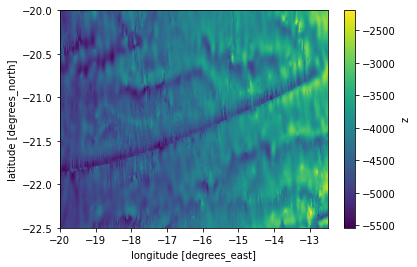

In [4]:
ds = xr.open_dataset("../../data/Tozer2019_bathymetry.nc")
ds = ds.sel(lon=slice(-20,-12.5), lat=slice(-22.5,-20.))

R = 6.371e6
circ = 2.*np.pi*R

ds = ds.assign_coords({
    'X': (ds['lon'] - ds['lon'].isel(lon=0)) * circ/360. * np.cos(np.deg2rad(ds['lat'].sel(lat=-21.3, method='nearest'))),
    'Y': (ds['lat'] - ds['lat'].isel(lat=0)) * circ/360.
})
ds['z'].plot()
ds.to_netcdf(input_path+"geocoords_original.nc")


ds

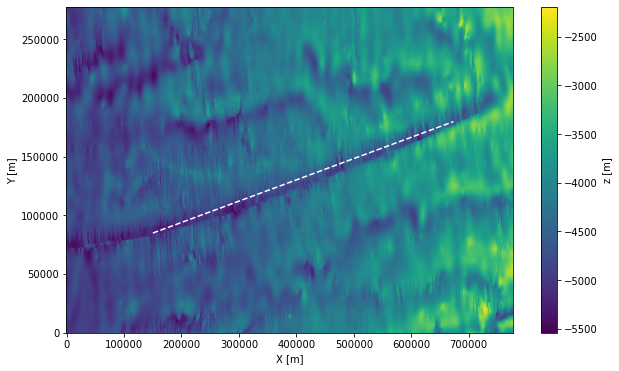

In [5]:
plt.figure(figsize=(10,6))
lats_deg = [-21.735, -20.88]; lons_deg = [-18.55, -13.5]
lats_dist = ds['Y'].sel(lat=lats_deg, method='nearest')
lons_dist = ds['X'].sel(lon=lons_deg, method='nearest')

q = ds['z'].plot(x='X', y='Y')
q.colorbar.set_label('z [m]')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.plot(lons_dist, lats_dist, 'w--')

#plt.savefig("../../figures/BBTRE/config_canyon.png", dpi=100., bbox_inches='tight')

#### Rotate into along-canyon and cross-canyon coordinates

In [6]:
canyon_angle = np.arctan(np.diff(lats_dist)/np.diff(lons_dist))

In [7]:
Xr_1d = np.arange(0., Lx, dx)[np.newaxis,:]
Yr_1d = np.arange(0., Ly, dy)[:,np.newaxis]

#### Interpolate onto subdomain with new rotated coordinate frame

In [8]:
X = xr.DataArray(
    data = Xr_1d*np.cos(canyon_angle) - Yr_1d*np.sin(canyon_angle),
    coords = {'Yr': Yr_1d.flatten(), 'Xr': Xr_1d.flatten()},
    dims = ['Yr', 'Xr']
)
Y = xr.DataArray(
    data = Yr_1d*np.cos(canyon_angle) + Xr_1d*np.sin(canyon_angle),
    coords = {'Yr': Yr_1d.flatten(), 'Xr': Xr_1d.flatten()},
    dims = ['Yr', 'Xr']
)

<xarray.Dataset>
Dimensions:  (Xr: 1, Yr: 1)
Coordinates:
    lon      (Yr, Xr) float64 -18.55
    lat      (Yr, Xr) float64 -21.74
    X        float64 1.502e+05
    Y        float64 8.479e+04
  * Yr       (Yr) float64 0.0
  * Xr       (Xr) float64 0.0
Data variables:
    z        (Yr, Xr) float64 -5.095e+03

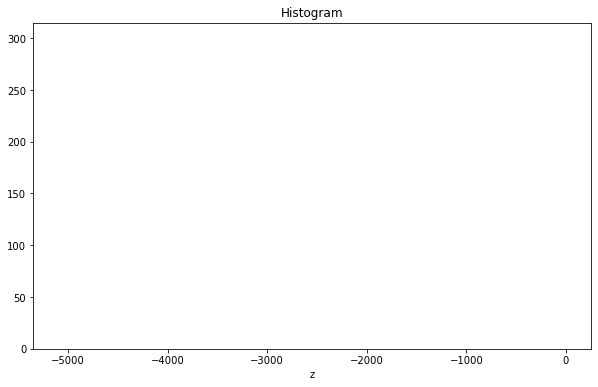

In [12]:
newds = xr.Dataset()
newds['z'] = (
    ds['z']
    .swap_dims({'lon':'X', 'lat':'Y'})
    .interp(X=X+lons_dist[0], Y=Y+lats_dist[0]-Ly/2)
)

plt.figure(figsize=(10,6))
newds['z'].plot()
plt.plot(newds['Xr'], 0.*newds['Xr'] + Ly/2, "w--")
newds

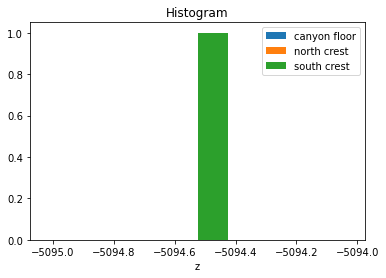

In [14]:
newds['z'].sel(Yr=3e4, method='nearest').plot(label='canyon floor')
newds['z'].isel(Yr=0).plot(label='north crest')
newds['z'].isel(Yr=-1).plot(label='south crest')
plt.legend()

#### Remove (and record) mean slope of canyon

In [15]:
slopeAngle, b = 0.0012618506382207175, -1.1236350572859935e-12
print(f"θ = {slopeAngle}")

newds['z_slope'] = slopeAngle * newds['Xr'] + b

newds['z_with_slope'] = newds['z'].copy()
newds['z'] = newds['z'] - newds['z_slope']

newds['z'] = 0.*newds['z']

θ = 0.0012618506382207175


#### Stretched vertical grid

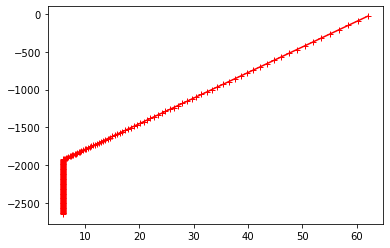

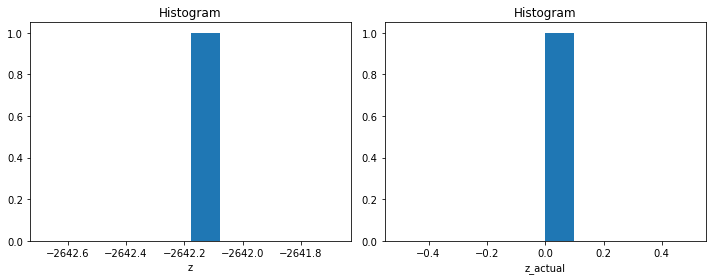

In [16]:
nz_vary = np.int(nz*nz_vary_frac)
dz = dz0 * np.ones((nz))[:,np.newaxis,np.newaxis]*np.ones((nz,ny,nx))
dz[nz_vary:,:,:] = dz[nz_vary,0,0]*1.03**np.arange(0,nz-nz_vary,1.0)[:,np.newaxis,np.newaxis]*np.ones((nz-nz_vary,ny,nx))
Hz = sum(dz[:,0,0])

x = np.arange(dx/2.0,Lx,dx)[np.newaxis,np.newaxis,:]*np.ones((nz,ny,nx))
y = np.arange(dy/2.0,Ly,dy)[np.newaxis,:,np.newaxis]*np.ones((nz,ny,nx))
z = (-Hz + np.cumsum(dz,axis=0) - dz/2.0)

min_elv = newds['z'].min().values # minimum elevation
Hbot = newds['z'] - min_elv - (Hz - dz0)
Hremoved = newds['z_slope'] + min_elv
newds['z_actual'] = newds['z']+Hremoved

plt.figure()
plt.plot(dz[:,0,0],z[:,0,0],"r-+")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
Hbot.plot()
plt.subplot(1,2,2)
newds['z_actual'].plot()
plt.tight_layout()

newds.attrs['min_elv'] = min_elv
newds.attrs['Hz'] = Hz
newds.attrs['dz0'] = dz0

newds.to_netcdf(input_path+"geocoords.nc")

#### Initial conditions

In [17]:
gamma = (N**2)/(gravity*tAlpha)
gamma_eps = gamma*1.e-4

U = np.zeros((nz, ny, nx))
V = np.zeros((nz, ny, nx))

T = np.zeros((nz, ny, nx))
T += np.random.normal(size=(nz, ny, nx),scale=2.e-8)/(gravity*tAlpha) # Callies2018 initial perturbation

print("Temperature Lapse Rate is: "+np.str((N**2)/(gravity*tAlpha)))

Temperature Lapse Rate is: 0.0008613659531090722


#### Forcing

In [18]:
# generate 3D vertical eddy diffusivity field
K = np.zeros((nz,ny,nx))
for i in range(nx):
    for j in range(ny):
        K[:, j, i] = k0 + k1*np.exp(-(z[:,0,0] - Hbot[j,i].values)/d)
K[K>(k1+k0)] = k1+k0

In [19]:
if kappa_const:
    mask = z >= Hbot.values
    Kav = np.sum(K*dz*mask)/np.sum(dz*mask)
    K = Kav*np.ones_like(K)

#### Write init files

In [20]:
# Reverse vertical axis so first index is at the surface and transpose axes
U = U[::-1,:,:]
V = V[::-1,:,:]
T = T[::-1,:,:]
K = K[::-1,:,:]
dz = dz[::-1,:1,:1]

# save input data as binary files
newFile = open(input_path+"U.init", "wb")
newFile.write(bytes(U.astype('>f8')))
newFile.close()

newFile = open(input_path+"V.init", "wb")
newFile.write(bytes(V.astype('>f8')))
newFile.close()

newFile = open(input_path+"T.init", "wb")
newFile.write(bytes(T.astype('>f8')))
newFile.close()

newFile = open(input_path+"kappa.init", "wb")
newFile.write(bytes(K.astype('>f8')))
newFile.close()

newFile = open(input_path+"topog.init", "wb")
newFile.write(bytes(Hbot[:,:].values.astype('>f8')))
newFile.close()

newFile = open(input_path+"delZ.init", "wb")
newFile.write(bytes(dz[:,0,0].astype('>f8')))
newFile.close()

In [22]:
import os
os.system(f"cp ./gendata_BBTRE_idealized-1D-Pr230.ipynb {input_path}");